In [2]:
%cd /content/drive/MyDrive/twitter-poll-topic-clustering-main
!pwd

/content/drive/MyDrive/twitter-poll-topic-clustering-main
/content/drive/MyDrive/twitter-poll-topic-clustering-main


In [3]:
import json
from abc import abstractmethod
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from prep import Reader, Preprocessor, SentenceTransformerEmbedding
from clusterers import KMeansClusterer, AgglomerativeClusterer, HDBSCANClusterer


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# !pip install sentence_transformers

In [8]:
class Config:
    def __init__(self):
        self.link_to_dataset = 'decahose_polls_2021-08_100k.txt'

        self.only_english = True
        self.only_retweeted = True
        self.positional = True
        # self.only_retweeted = True

        self.KforKMeans = 25

config = Config()

In [9]:
df = Reader(config.link_to_dataset).read()

In [10]:
preprocessor = Preprocessor(df)
preprocessor.preprocess_df(only_english = config.only_english, only_retweeted = config.only_retweeted, positional = config.positional)
preprocessor.preprocess_text()

df = preprocessor.get_dataframe()

dropping quote_count
dropping contributors
dropping reply_count
dropping favorite_count
dropping retweeted
dropping coordinates
dropping retweet_count
dropping favorited
dropping geo
dropping filter_level

    truncated                                               text  \
0       False  RT @CaesarsSports: Thursday Dingers is coming ...   
1       False  RT @Openly: Should sports bodies allow interse...   
2       False                       RT @TheSkyBlueHub: Defenders   
10      False  RT @wuptoy: Toy really grinding hard on 76... ...   
11      False  RT @cinder_katt: If its bluer ill see what i c...   

    is_quote_status  in_reply_to_status_id                   id  \
0             False                    NaN  1422682179906199556   
1             False                    NaN  1422682226488188940   
2             False                    NaN  1422682282679226368   
10            False                    NaN  1422682421938503681   
11            False                    NaN  142268

In [11]:
# df = df.sample(10000)

In [12]:
if config.positional:
    embeddings = SentenceTransformerEmbedding().embed(df.positional)
else:
    embeddings = SentenceTransformerEmbedding().embed(df.text)
print(embeddings.shape)

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

(11053, 384)


K-Means Clustering

In [13]:
clusterer = KMeansClusterer(k = config.KforKMeans)
clusterer.fit(embeddings)

In [14]:
clusterer.summarise_clusters(df, n = 5)

Cluster Number 0 - 
Elements in Cluster: 260
Average Words in the Poll: 15.6

Samples - 
1. RT @bidorbuy_co_za: Sneaker preview. Which sportswear brand gets your vote? #BattleOfTheBrands
2. RT @CelPiazzi: Please RT the world's biggest Soccer Clubs Twitter Championship

Which is your favorite club?

Round of 512

Heat 69/128

@C…
3. RT @cristiano_peak: Bias aside, Who’s the better player in your opinion? 

Feel free to explain your take.
4. RT @AnswerThePole: @BleacherReport Is Nick Saban a better football coach than Bill Belichick?
5. RT @spr5687: Bolton Vs Mk Dons 

Bolton are back in League one after one season away and host a dons side who are currently managerless wit…

Cluster Number 1 - 
Elements in Cluster: 450
Average Words in the Poll: 17.324444444444445

Samples - 
1. RT @therealinformer: You can pick one person in their primes to score four touchdowns in one game for Polk High School?
2. RT @JayStephens07: Best Heisman Trophy Winner Since 1988
Round of 32

Rashaan Salaam vs 

In [15]:
path = '/content/drive/MyDrive/twitter-poll-topic-clustering-main/outputs1'
clusterer.save(df, path)

HDBSCAN Clustering

In [18]:
# !pip install hdbscan

In [19]:
hdbclusterer = HDBSCANClusterer(min_cluster_size = 500, min_samples = 1)
hdbclusterer.fit(embeddings)

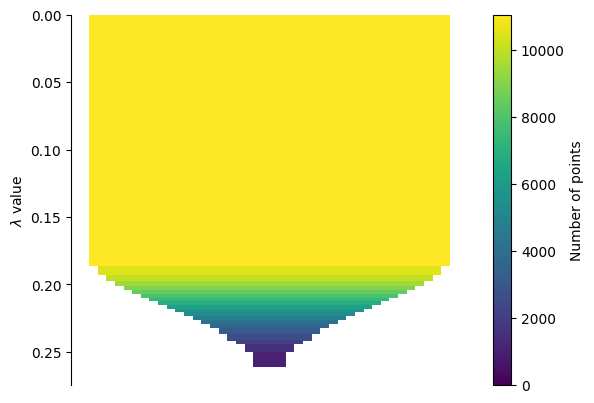

In [20]:
hdbclusterer.plot_dendrogram()

Agglomerative Clustering

In [21]:
agglo_clusterer = AgglomerativeClusterer()
agglo_clusterer.fit(embeddings)

In [22]:
clusterer.summarise_clusters(df)

Cluster Number 0 - 
Elements in Cluster: 260
Average Words in the Poll: 15.6

Samples - 
1. RT @Kevin_Miller11: Best French fry 🍟
2. RT @columbia_soccer: If anyone wants to watch an entertaining soccer game our alumni game is home starting  at 1pm! Excited to have it back…
3. RT @premierleague: Choose wisely 🧐
4. RT @ThomasTankMerch: Which TWR Henry is the best?
5. RT @SOHAILK91409333: Select your favorite player who you think is a good player? ❤
#MessiPSG #MessiQuedate #Messi #MessiForever #باريس_سان_…
6. RT @emmasear89: Quick poll for the cricket clubs around the country. Please help me get this seen by as many as possible...

Are dogs (on l…
7. RT @UEFA: 🏆 Who will win the UEFA #SuperCup?

Cluster Number 1 - 
Elements in Cluster: 450
Average Words in the Poll: 17.324444444444445

Samples - 
1. RT @Frank_A_Quiller: The Super League of Twats Week 18
Tier 3
2. RT @DFFMoose: How about a poll between two rookie  running backs who BOTH have the potential to make an immediate impact for th

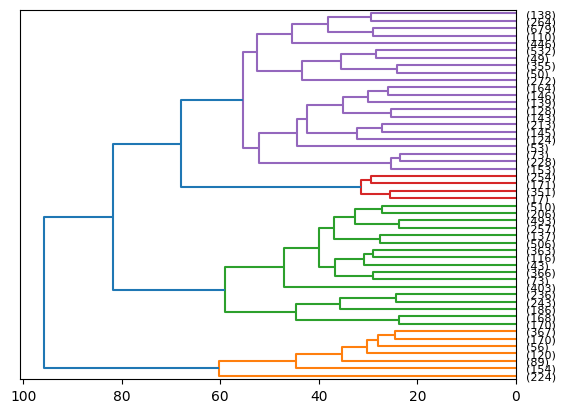

In [23]:
agglo_clusterer.plot_dendrogram(truncate_mode = 'lastp', p = 50)

In [24]:
childs = agglo_clusterer.clusterer.children_
print(childs)

[[ 1277  9666]
 [ 3489  5764]
 [ 8066  8841]
 ...
 [22079 22099]
 [22100 22102]
 [22101 22103]]


In [31]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, pairwise_distances_argmin_min
from sklearn.datasets import make_blobs
from scipy.stats import mode

def create_bootstrap_sample(data):
    """Create a bootstrap sample of the given data."""
    n_samples = len(data)
    embed_data = data.sample(n=n_samples)
    embeddings = SentenceTransformerEmbedding().embed(embed_data.text)
    return embeddings

def cluster_and_label(data, n_clusters):
    """Perform k-means clustering and return cluster labels."""
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    return kmeans.cluster_centers_,kmeans.labels_

def stability_analysis(data, n_clusters, n_iterations=10):
    """Perform stability analysis on clustering."""
    embeddings = SentenceTransformerEmbedding().embed(data.text)
    print("formed embeddings")
    true_centroid,reference_labels = cluster_and_label(embeddings, n_clusters)
    print("formed reference_labels")
    scores = []
    count = 0
    for _ in range(n_iterations):
        print(count)
        count +=1
        sample = create_bootstrap_sample(data)
        new_centroid,sample_labels = cluster_and_label(sample, n_clusters)
        _, closest_centroids = pairwise_distances_argmin_min(true_centroid, new_centroid)
        new_labels = np.zeros_like(sample_labels)
        for i, label in enumerate(closest_centroids):
            new_labels[sample_labels == label] = i
        score = adjusted_rand_score(reference_labels, new_labels)
        scores.append(score)

    return np.mean(scores)


# Example usage
# data, _ = make_blobs(n_samples=1000, centers=25, random_state=42)  # Generating some synthetic data
n_clusters = 25  # Assuming we want to test stability for 4 clusters
print(df.head(500).text)
average_score = stability_analysis(df.head(100), n_clusters)

0       RT @CaesarsSports: Thursday Dingers is coming ...
1       RT @Openly: Should sports bodies allow interse...
2                            RT @TheSkyBlueHub: Defenders
10      RT @wuptoy: Toy really grinding hard on 76... ...
11      RT @cinder_katt: If its bluer ill see what i c...
                              ...                        
2918    RT @honeyapple_xml: bored\n\nlike - if u think...
2919        RT @poll_nct: What your favorite member? #NCT
2923         RT @RazorbackDrite: Of the 4: best popsicle?
2931    RT @durendals: so for a variety of reasons i d...
2934         RT @Lucysaesthetic1: hello there, TL active?
Name: text, Length: 500, dtype: object
formed embeddings
formed reference_labels
0
1
2
3
4
5
6
7
8
9


In [34]:
print(f"Average Adjusted Rand Index over {10} iterations: {average_score}")

Average Adjusted Rand Index over 10 iterations: 0.0006840389147766602


In [ ]:
# Another alternative to this is copy paste all the sentences and ask the question on the ChatGPT UI directly
# We have the GPT 4 so we could upload the output.txt files directly along with the prompt question
# There's a limit of 20 free api calls after that we just uploaded txt files on the gpt 4 ui along with the prompt to produce results

In [6]:
# !pip install openai

In [ ]:
import openai

def upload_document(file_path, api_key):
    openai.api_key = api_key

    with open(file_path, 'rb') as file:
        response = openai.File.create(file=file, purpose='answers')

    return response.id


In [ ]:
def answer_question_with_context(question, file_id, api_key):
    openai.api_key = api_key

    response = openai.Answer.create(
        model="gpt-4-1106-preview",
        question=question,
        file=file_id,
        search_model="gpt-4-1106-preview",
        max_rerank=10,
        max_tokens=150,
        stop=["\n"]
    )

    return response.answers[0]


In [ ]:
api_key = ""

for file_path in glob.glob('/content/drive/MyDrive/twitter-poll-topic-clustering-main/outputs1/*.txt'):

    file_id = upload_document(file_path, api_key)

    question = "What is the common topic or theme in these sentences?"
    answer = answer_question_with_context(question, file_id, api_key)
    print(file_path, answer)
